In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [3]:
# Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [4]:
import os
import shutil

# Define the base path
base_path = r"C:\Users\rhenz\Documents\PlantVillage"

# Define the source and destination paths
source_paths = [
    os.path.join(base_path, "Tomato_Bacterial_spot"),
    os.path.join(base_path, "Tomato__Tomato_YellowLeaf__Curl_Virus"),
    os.path.join(base_path, "Tomato__Tomato_mosaic_virus"),
    os.path.join(base_path, "Tomato_healthy")
]

# Define the destination path
destination_path = r"C:\Users\rhenz\Downloads\DSP Final Project"

# Copy files
for source_path in source_paths:
    for root, dirs, files in os.walk(source_path):
        for file in files:
            source_file_path = os.path.join(root, file)
            destination_file_path = os.path.join(destination_path, file)
            shutil.copy2(source_file_path, destination_file_path)


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=base_path,
            shuffle=True,
            image_size=(IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE,
)

Found 20638 files belonging to 15 classes.


In [6]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[14  8  5 12 10 13  5  2  3  0  9 10 10  9  0  9 11  8 14 10  7  0  1 12
  3  7  7 14 11  9 10  8]


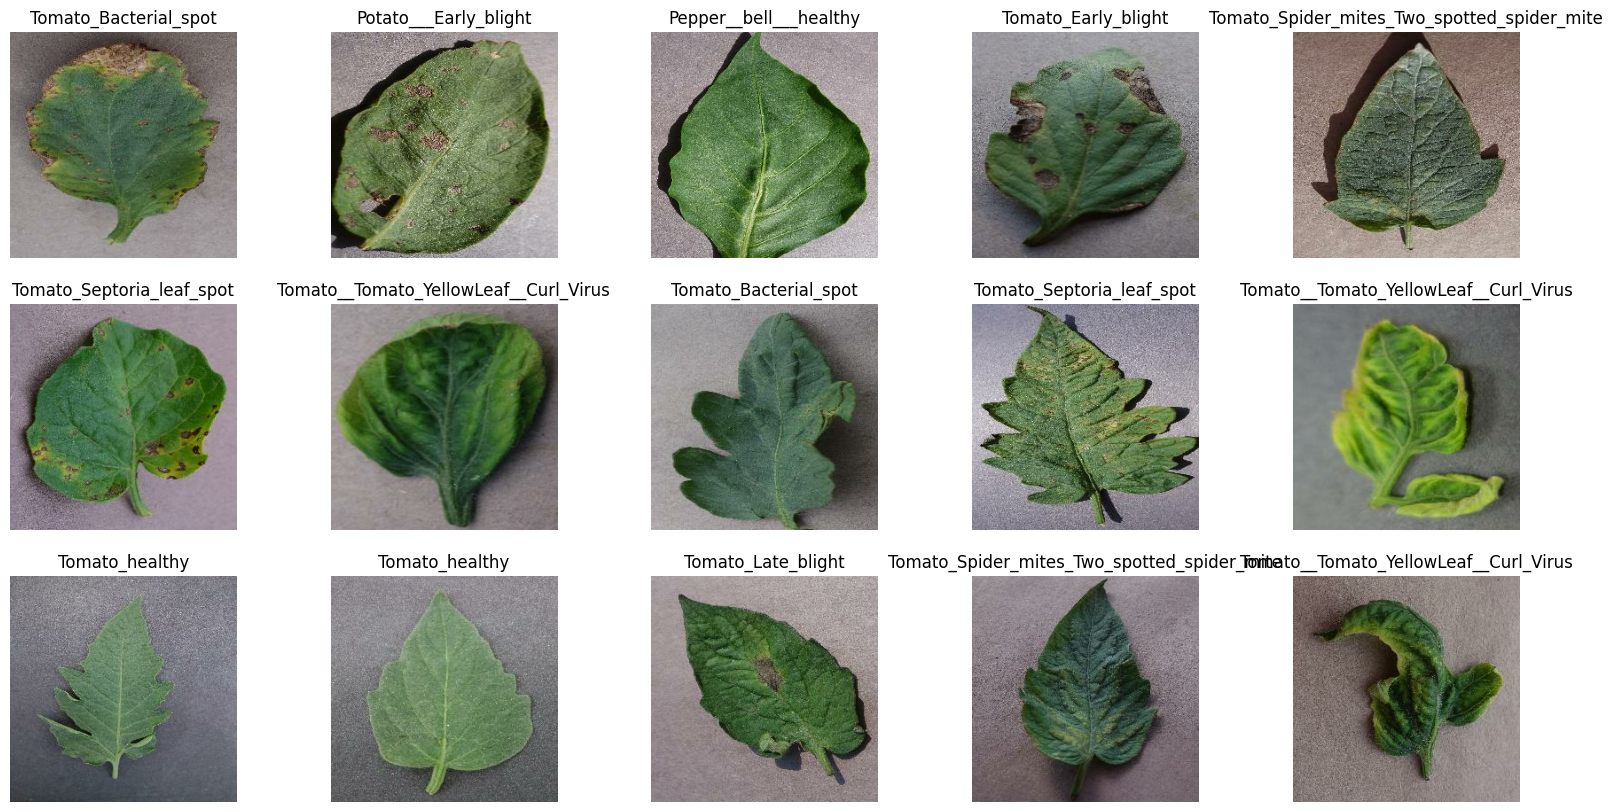

In [8]:
plt.figure(figsize=(20,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partitions(ds,train_split=0.8,test_split=0.1,valid_split=0.1,shuffle=True,shuffle_size=10000):
    assert  train_split+test_split+valid_split==1
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
    train_size = int(len(ds)*train_split)
    valid_size = int(len(ds)*valid_split)


    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)

    return train_ds ,test_ds, valid_ds

In [10]:
train_ds ,test_ds, valid_ds = get_dataset_partitions(dataset)

In [11]:
print(len(train_ds))
print(len(test_ds))
print(len(valid_ds))

516
65
64


In [12]:
# performance improving by both using CPU and GPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
#Image Preprocessing
rescale_and_resize=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,# will resize to the IMAGE_SIZE if there's any issue
    layers.experimental.preprocessing.Rescaling(1./255)  # Normalization
])

In [14]:
#data augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
#Building a Model

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)


model = models.Sequential([
    rescale_and_resize,
    data_augmentation,

    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [17]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [18]:
EPOCHS = 10

In [19]:
if 'history' not in locals():
    history = []
#model training
history.append(
    model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        validation_data=valid_ds,
        verbose=1,
        epochs=EPOCHS
    )
)

Epoch 1/10




516/516 [==============================] - 780s 1s/step - loss: 2.1482 - accuracy: 0.2912 - val_loss: 1.7774 - val_accuracy: 0.4448
Epoch 2/10
516/516 [==============================] - 721s 1s/step - loss: 1.3526 - accuracy: 0.5407 - val_loss: 1.8443 - val_accuracy: 0.4600
Epoch 3/10
516/516 [==============================] - 702s 1s/step - loss: 0.8853 - accuracy: 0.6931 - val_loss: 1.5313 - val_accuracy: 0.5596
Epoch 4/10
516/516 [==============================] - 691s 1s/step - loss: 0.6860 - accuracy: 0.7614 - val_loss: 1.1884 - val_accuracy: 0.6333
Epoch 5/10
516/516 [==============================] - 680s 1s/step - loss: 0.5443 - accuracy: 0.8111 - val_loss: 0.8446 - val_accuracy: 0.7236
Epoch 6/10
516/516 [==============================] - 599s 1s/step - loss: 0.4767 - accuracy: 0.8350 - val_loss: 0.6425 - val_accuracy: 0.7886
Epoch 7/10
516/516 [==============================] - 584s 1s/step - loss: 0.3869 - accuracy: 0.8677 - val_loss: 0.6195 - val_accuracy: 0.8027
Epoch 8/

In [20]:
scores = model.evaluate(test_ds)
scores

65/65 [==============================] - 68s 329ms/step - loss: 0.6547 - accuracy: 0.8032


[0.6546740531921387, 0.8031761050224304]

In [21]:
#Plotting Model Accuracy
acc = []
val_acc = []
loss = []
val_loss = []

for h in history:
    acc.extend(h.history['accuracy'])
    val_acc.extend(h.history['val_accuracy'])
    loss.extend(h.history['loss'])
    val_loss.extend(h.history['val_loss'])

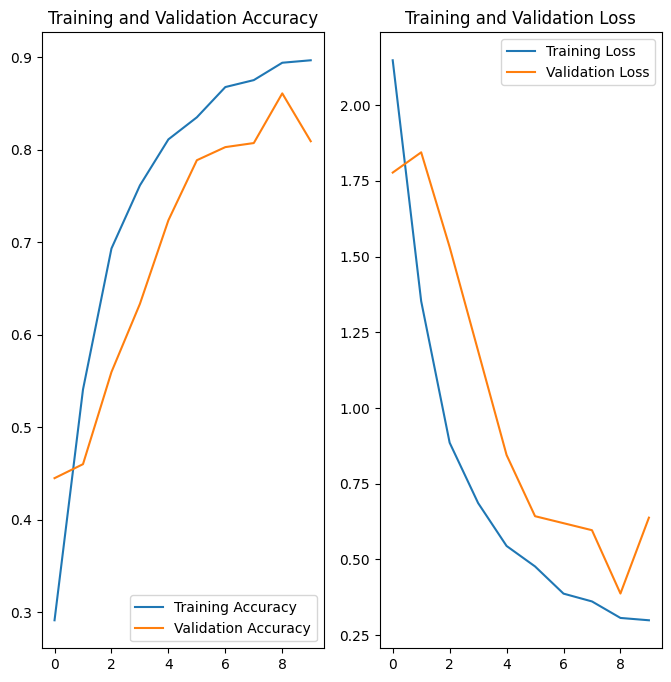

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato__Tomato_YellowLeaf__Curl_Virus
1/1 [==============================] - 1s 1s/step
predicted label: Tomato__Tomato_YellowLeaf__Curl_Virus


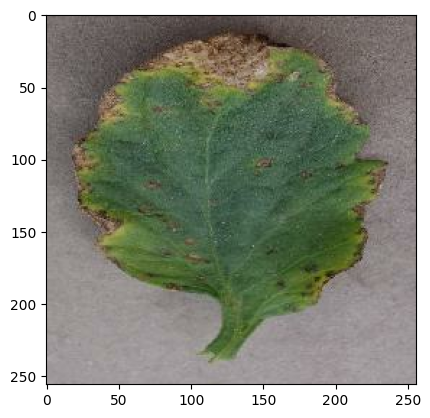

In [23]:
#Running prediction on a sample image
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])


    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    break

In [25]:
#Predictions
def predict_tomato_diseases(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)


    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 41ms/step


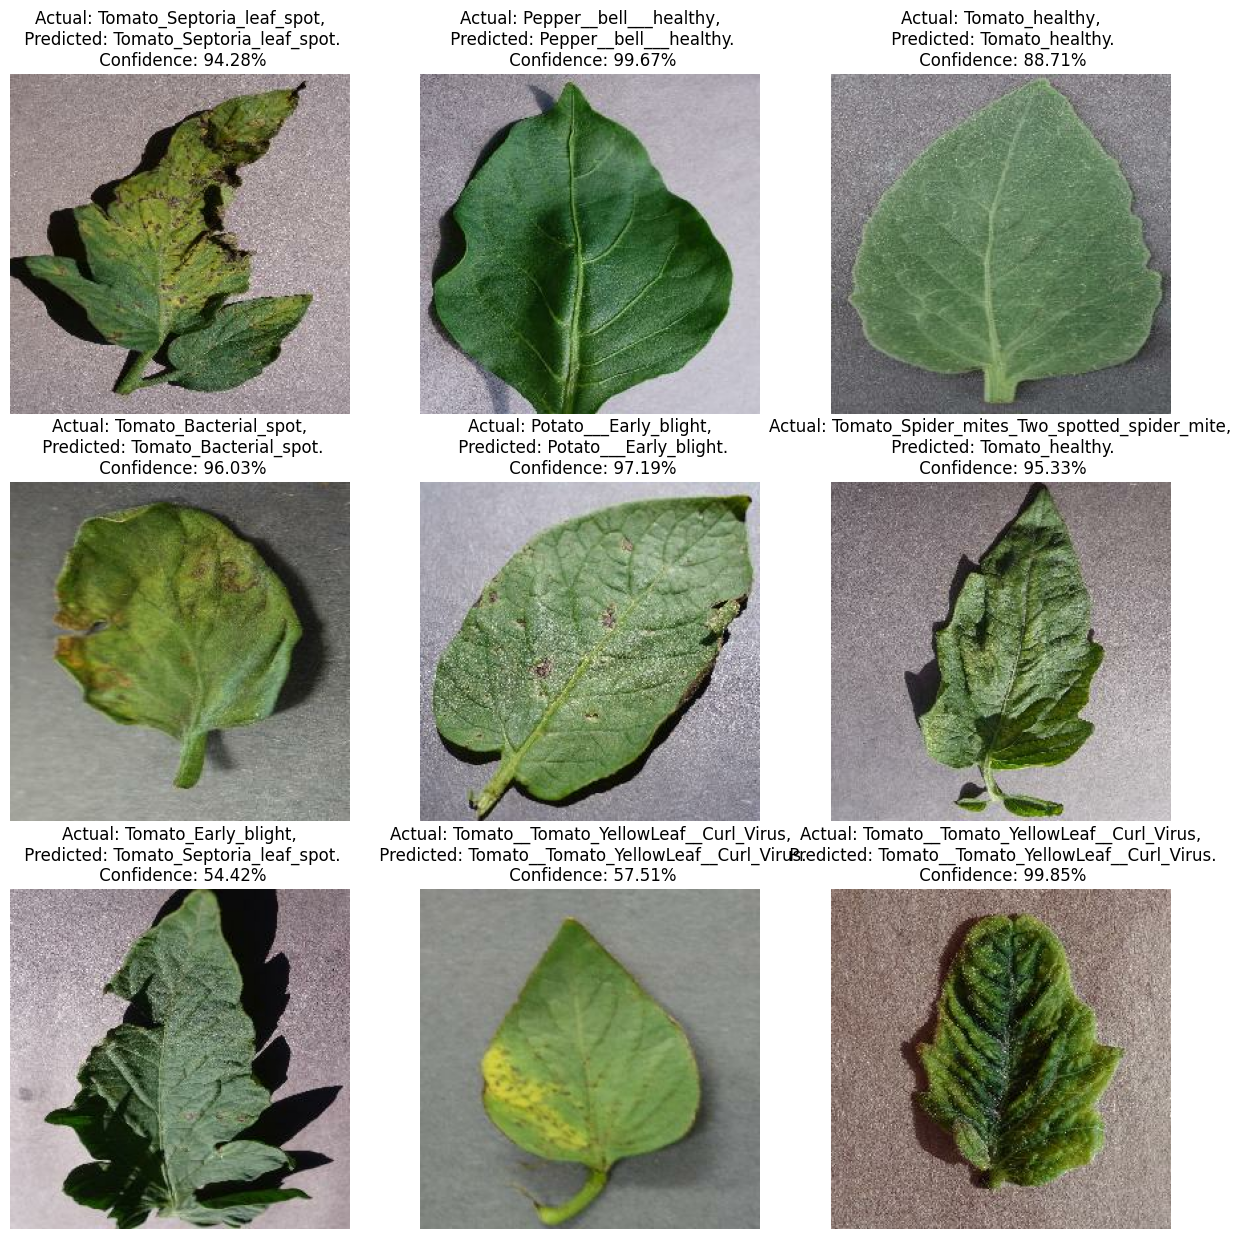

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict_tomato_diseases(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [27]:
#Saving the Model
!mkdir models
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/tomato_{model_version}")

INFO:tensorflow:Assets written to: models/tomato_1\assets


INFO:tensorflow:Assets written to: models/tomato_1\assets


In [28]:
model.save("tomato.h5")

C:\Users\rhenz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
os.chdir(r'C:\Users\rhenz\Downloads\DSP Final Project')

from IPython.display import FileLink
FileLink(r'tomato.h5')

C:\Users\rhenz\Downloads\DSP Final Project\tomato.h5